In [1]:
import os
import tarfile
from mxnet import gluon

data_root = '/mnt/data'
voc_root = data_root + '/VOCdevkit/VOC2012'

In [2]:
from mxnet import image

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

In [3]:
import sys
sys.path.append('..')
import utils

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

<Figure size 1200x800 with 6 Axes>

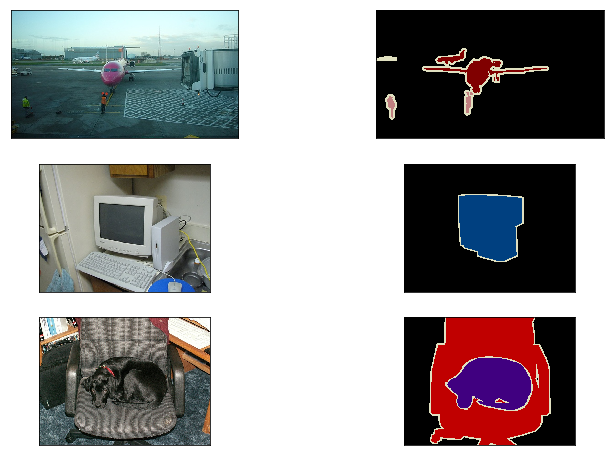

In [4]:
%matplotlib inline
utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

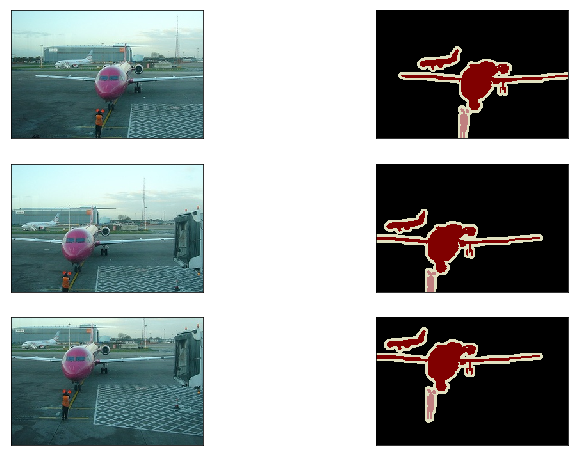

In [5]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

In [6]:
dir(image)

['Augmenter',
 'BrightnessJitterAug',
 'CastAug',
 'CenterCropAug',
 'ColorJitterAug',
 'ColorNormalizeAug',
 'ContrastJitterAug',
 'CreateAugmenter',
 'CreateDetAugmenter',
 'CreateMultiRandCropAugmenter',
 'DetAugmenter',
 'DetBorrowAug',
 'DetHorizontalFlipAug',
 'DetRandomCropAug',
 'DetRandomPadAug',
 'DetRandomSelectAug',
 'ForceResizeAug',
 'HorizontalFlipAug',
 'HueJitterAug',
 'ImageDetIter',
 'ImageIter',
 'LightingAug',
 'RandomCropAug',
 'RandomGrayAug',
 'RandomOrderAug',
 'RandomSizedCropAug',
 'ResizeAug',
 'SaturationJitterAug',
 'SequentialAug',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'center_crop',
 'color_normalize',
 'copyMakeBorder',
 'cv2',
 'det',
 'detection',
 'fixed_crop',
 'image',
 'imdecode',
 'imread',
 'imresize',
 'io',
 'json',
 'logging',
 'nd',
 'np',
 'numeric_types',
 'os',
 'print_function',
 'random',
 'random_crop',
 'random_size_crop',
 'r

In [7]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [8]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

In [9]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
<NDArray 10x10 @cpu(0)>

In [10]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train=train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        data = data.transpose((2,0,1))
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

In [1]:
# height x width
input_shape = (160, 240)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

NameError: name 'VOCSegDataset' is not defined

In [1]:
batch_size = 4
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

NameError: name 'gluon' is not defined

In [2]:
from mxnet.gluon import nn

conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape=(1,3,64,64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

NameError: name 'nd' is not defined

In [3]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True, root='/mnt/ckpt/gluon_models')

(pretrained_net.features[-4:], pretrained_net.output)

Model file is not found. Downloading.


([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

In [4]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

x = nd.random.uniform(shape=(1,3,*input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

NameError: name 'nd' is not defined

In [5]:
dir(models.resnet18_v2)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']